In [1]:
import cftime
import datetime
import glob
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import pandas as pd
from scipy import signal
from scipy.optimize import curve_fit

%matplotlib widget

In [2]:
def window_mean(arr, window_size):
    """
    Compute the window mean (moving average) of an array, keeping the output the same length as the input array and handling NaN values.
    
    Parameters:
    arr (list or np.ndarray): Input array.
    window_size (int): The size of the window to compute the mean.
    
    Returns:
    np.ndarray: Array of window means, padded to the same length as the input array.
    """
    # Convert the input array to a numpy array if it isn't one already
    arr = np.asarray(arr, dtype=float)
    
    # Check if the window size is greater than the array length
    if window_size > len(arr):
        raise ValueError("Window size should be less than or equal to the length of the array.")
    
    # Use pandas rolling function to calculate the window mean, handling NaN values
    result = pd.Series(arr).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
    
    return result

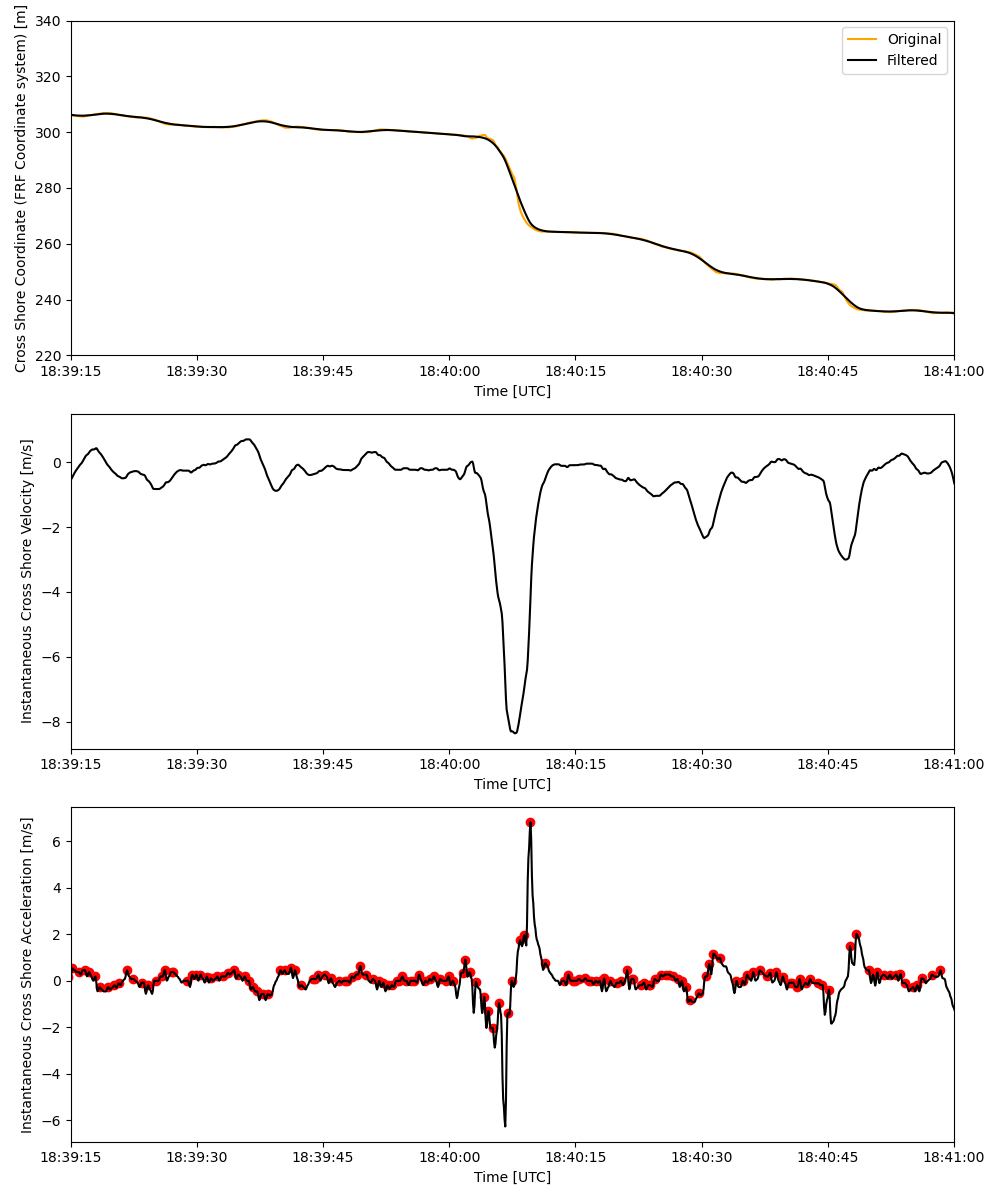

In [3]:
# Open the mission file 
mission_nc = '../../data/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc, mode='r')
trajectory_num = 5

# Extract the x and y locations of each buoy in the FRF coordinate system
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])

# Get the time values of the mission
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
delta_t = (time[1]-time[0]).total_seconds()

# Define the window size
window_size = 36

# Filter x
x = np.ma.filled(x_locations[trajectory_num,:], np.NaN)
x_filtered = window_mean(x, window_size)

# Filter y 
y = np.ma.filled(y_locations[trajectory_num,:], np.NaN)
y_filtered = window_mean(y, window_size)

# Compute the instantaneous velocity from the filtered signal
instantaneous_x_vel = np.gradient(x_filtered, delta_t)
instantaneous_y_vel = np.gradient(y_filtered, delta_t)

# Compute the instantaneous acceleration from the filtered signal
instantaneous_x_accel = np.gradient(instantaneous_x_vel, delta_t)
instantaneous_y_accel = np.gradient(instantaneous_y_vel, delta_t)

# Find the Peaks in the Acceleration time series
peak_indices = signal.find_peaks(instantaneous_x_accel)[0]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10,12))
ax1.plot(time, x, color='orange', label='Original')
ax1.plot(time, x_filtered, color='k', label='Filtered')
ax1.set_xlabel('Time [UTC]')
ax1.set_ylabel('Cross Shore Coordinate (FRF Coordinate system) [m]')
ax1.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))
ax1.set_ylim(220, 340)
ax1.legend()

# Instantaneous Velocity
ax2.plot(time, instantaneous_x_vel, color='k')
ax2.set_xlabel('Time [UTC]')
ax2.set_ylabel('Instantaneous Cross Shore Velocity [m/s]')
ax2.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))

# Instantaneous Acceleration
ax3.plot(time, instantaneous_x_accel, color='k')
ax3.scatter(time[peak_indices], instantaneous_x_accel[peak_indices], color='r')
ax3.set_xlabel('Time [UTC]')
ax3.set_ylabel('Instantaneous Cross Shore Acceleration [m/s]')
ax3.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))

plt.tight_layout()

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_53684/936280616.py:6: SyntaxWarning: invalid escape sequence '\p'
  ax.axvline(np.nanmean(instantaneous_x_accel) + 2*accel_std, color='k', label='$\pm$2 stds from mean')


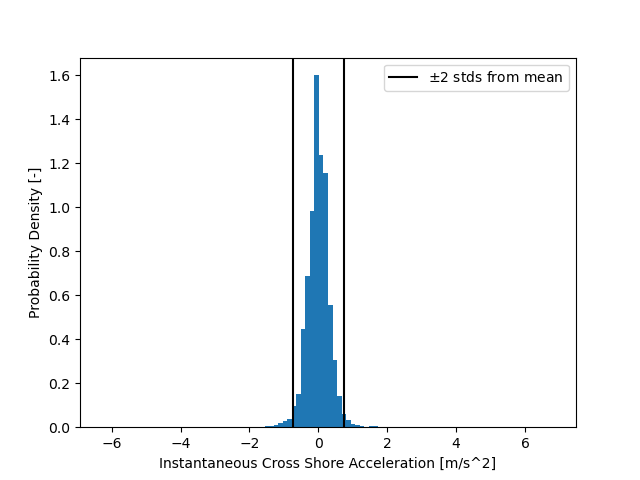

In [4]:
# Compute the standard deviation
accel_std = np.nanstd(instantaneous_x_accel)

fig, ax = plt.subplots()
ax.hist(instantaneous_x_accel, bins=100, density=True)
ax.axvline(np.nanmean(instantaneous_x_accel) + 2*accel_std, color='k', label='$\pm$2 stds from mean')
ax.axvline(np.nanmean(instantaneous_x_accel) - 2*accel_std, color='k')
ax.set_xlabel('Instantaneous Cross Shore Acceleration [m/s^2]')
ax.set_ylabel('Probability Density [-]')
ax.legend()

Text(0, 0.5, 'Instantaneous Cross Shore Acceleration [m/s]')

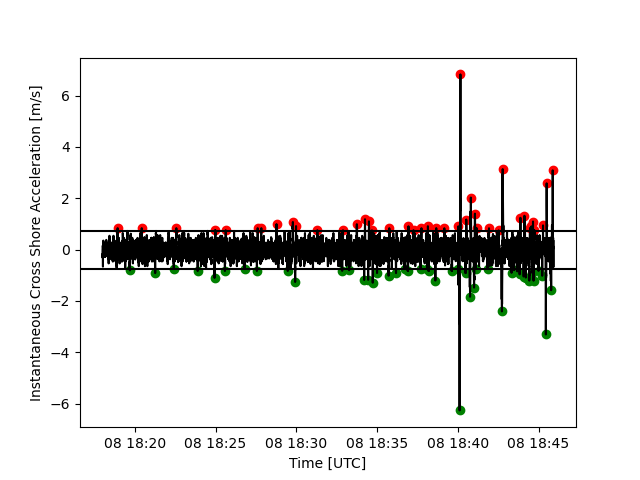

In [5]:
# Number of stds
n_stds = 2

# Find peaks greater than the 2std threshold
end_point_inds = signal.find_peaks(instantaneous_x_accel, height=np.nanmean(instantaneous_x_accel) + n_stds*accel_std, distance=48)[0]
start_point_inds = signal.find_peaks(-instantaneous_x_accel, height=np.nanmean(instantaneous_x_accel) + n_stds*accel_std, distance=48)[0]

fig, ax = plt.subplots()
ax.plot(time, instantaneous_x_accel, color='k')
ax.axhline(np.nanmean(instantaneous_x_accel) + n_stds*accel_std, color='k')
ax.axhline(np.nanmean(instantaneous_x_accel) - n_stds*accel_std, color='k')
ax.scatter(time[start_point_inds], instantaneous_x_accel[start_point_inds], color='g')
ax.scatter(time[end_point_inds], instantaneous_x_accel[end_point_inds], color='r')
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Instantaneous Cross Shore Acceleration [m/s]')
# ax.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))

(215.0, 320.0)

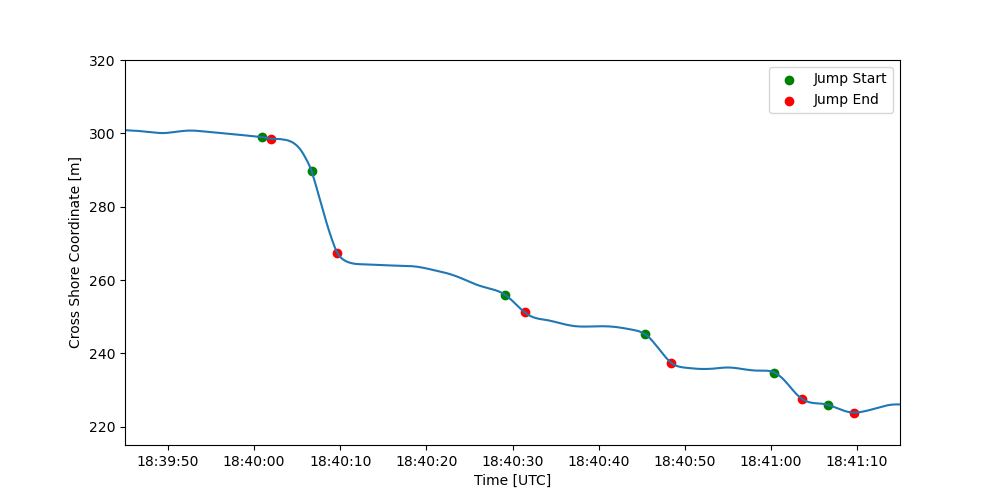

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, x_filtered)
ax.scatter(time[start_point_inds], x_filtered[start_point_inds], color='g', label='Jump Start')
ax.scatter(time[end_point_inds], x_filtered[end_point_inds], color='r', label='Jump End')
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Cross Shore Coordinate [m]')
ax.legend()
ax.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 45), datetime.datetime(2021, 10, 8, 18, 41, 15))
ax.set_ylim(215, 320)

Based on the most recent DUNEX Meeting (6/6/24) our best bet for picking out the jumps is to apply a thresholded peak finding algorithm to the velocity and then pick out start and end points as peaks in accelerations surrounding the velocity peak. This should be more robust to the threshold.

(18908.777256944446, 18908.77847222222)

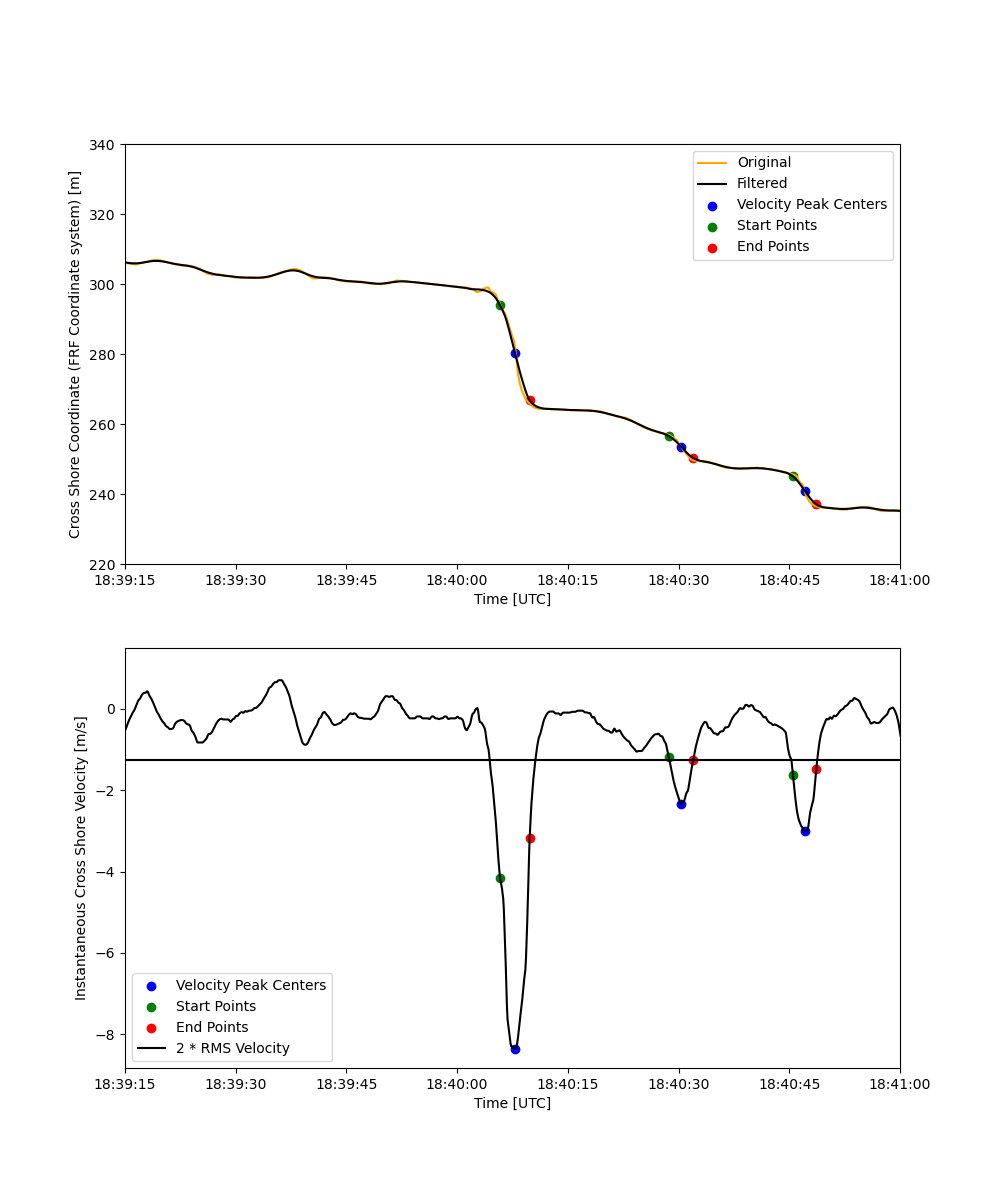

In [7]:
# Start from the top - smooth the cross shore time series and compute instantaneous cross shore velocity
# Open the mission file 
mission_nc = '../../data/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc, mode='r')
trajectory_num = 5

# Extract the x and y locations of each buoy in the FRF coordinate system
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])

# Get the time values of the mission
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
delta_t = (time[1]-time[0]).total_seconds()

# Define the window size
window_size = 36

# Filter x
x = np.ma.filled(x_locations[trajectory_num,:], np.NaN)
x_filtered = window_mean(x, window_size)

# Filter y 
y = np.ma.filled(y_locations[trajectory_num,:], np.NaN)
y_filtered = window_mean(y, window_size)

# Compute the instantaneous velocity from the filtered signal
instantaneous_x_vel = np.gradient(x_filtered, delta_t)
instantaneous_y_vel = np.gradient(y_filtered, delta_t)

# Compute the instantaneous acceleration from the filtered signal
instantaneous_x_accel = np.gradient(instantaneous_x_vel, delta_t)
instantaneous_y_accel = np.gradient(instantaneous_y_vel, delta_t)

# Find the Peaks in the Acceleration time series - note the negative sign is so that peaks are 
# positive during jumps since the buoys are moving towards the beach which is a decrease in the x coordinate
vel_threshhold = 2 * np.sqrt(np.nanmean(instantaneous_x_vel**2))
distance_between_peaks = int(3*(1/delta_t)) # 3 seconds between points
peak_vel_indices = signal.find_peaks(-instantaneous_x_vel, height=vel_threshhold, distance=distance_between_peaks)[0]

# Find the peak widths and start and end points of the peak
widths = signal.peak_widths(-instantaneous_x_vel, peak_vel_indices, rel_height=0.5)[0]

start_points = np.empty(peak_vel_indices.size, dtype=int)
end_points = np.empty(peak_vel_indices.size, dtype=int)
for n in np.arange(peak_vel_indices.size):
    start_points[n] = int(peak_vel_indices[n] - widths[n]//2)
    end_points[n] = int(peak_vel_indices[n] + widths[n]//2)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,12))
ax1.plot(time, x, color='orange', label='Original')
ax1.plot(time, x_filtered, color='k', label='Filtered')
ax1.scatter(time[peak_vel_indices], x_filtered[peak_vel_indices], color='b', label='Velocity Peak Centers')
ax1.scatter(time[start_points], x_filtered[start_points], color='g', label='Start Points')
ax1.scatter(time[end_points], x_filtered[end_points], color='r', label='End Points')
ax1.set_xlabel('Time [UTC]')
ax1.set_ylabel('Cross Shore Coordinate (FRF Coordinate system) [m]')
ax1.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))
ax1.set_ylim(220, 340)
ax1.legend()

# Instantaneous Velocity
ax2.plot(time, instantaneous_x_vel, color='k')
ax2.scatter(time[peak_vel_indices], instantaneous_x_vel[peak_vel_indices], color='b', label='Velocity Peak Centers')
ax2.scatter(time[start_points], instantaneous_x_vel[start_points], color='g', label='Start Points')
ax2.scatter(time[end_points], instantaneous_x_vel[end_points], color='r', label='End Points')
ax2.axhline(-vel_threshhold, color='k', label='2 * RMS Velocity')
ax2.set_xlabel('Time [UTC]')
ax2.set_ylabel('Instantaneous Cross Shore Velocity [m/s]')
ax2.legend()
ax2.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))


Using the peak widths function will have the same problems as the previous method that it is sensitive to the relative height that is required to be set so we do need to move to finding acceleration peaks that are surrounding velocity peak.

360
8265
8085
173
80
8258
8345


Text(0, 0.5, 'Instantaneous Cross Shore Acceleration [m/s^2]')

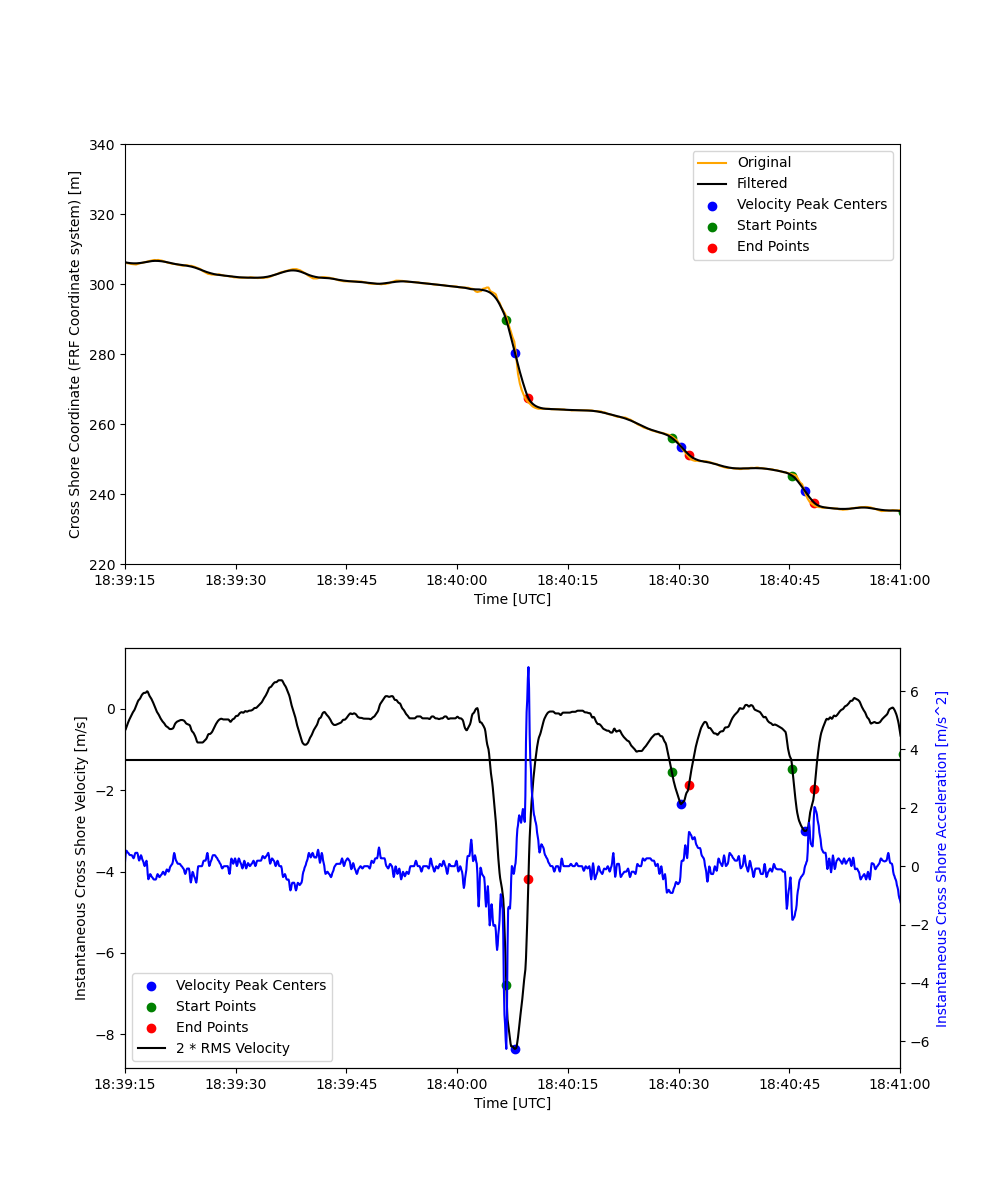

In [8]:
# Find the max and min values of acceleration surrounding the velocity peak
max_width = int(30 * (1/delta_t)) # 30 seconds surrounding the velocity peak event

n = 0
print(max_width)
print(peak_vel_indices[n])
print((peak_vel_indices[n]-max_width//2))
print(np.argmin(instantaneous_x_accel[(peak_vel_indices[0]-max_width//2):(peak_vel_indices[0])]))
print(np.argmax(instantaneous_x_accel[(peak_vel_indices[0]):(peak_vel_indices[0]+max_width//2)]))
start_point = peak_vel_indices[n] - (max_width//2 - np.argmin(instantaneous_x_accel[(peak_vel_indices[n]-max_width//2):(peak_vel_indices[n])]))
end_point = peak_vel_indices[n] + np.argmax(instantaneous_x_accel[(peak_vel_indices[n]):(peak_vel_indices[n]+max_width//2)])
print(start_point)
print(end_point)

# Automate this process
start_points = np.empty(peak_vel_indices.size, dtype=int)
end_points = np.empty(peak_vel_indices.size, dtype=int)
for n in np.arange(peak_vel_indices.size):
    start_points[n] = peak_vel_indices[n] - (max_width//2 - np.argmin(instantaneous_x_accel[(peak_vel_indices[n]-max_width//2):(peak_vel_indices[n])]))
    end_points[n] = peak_vel_indices[n] + np.argmax(instantaneous_x_accel[(peak_vel_indices[n]):(peak_vel_indices[n]+max_width//2)])

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,12))
ax1.plot(time, x, color='orange', label='Original')
ax1.plot(time, x_filtered, color='k', label='Filtered')
ax1.scatter(time[peak_vel_indices], x_filtered[peak_vel_indices], color='b', label='Velocity Peak Centers')
ax1.scatter(time[start_points], x_filtered[start_points], color='g', label='Start Points')
ax1.scatter(time[end_points], x_filtered[end_points], color='r', label='End Points')
ax1.set_xlabel('Time [UTC]')
ax1.set_ylabel('Cross Shore Coordinate (FRF Coordinate system) [m]')
ax1.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))
ax1.set_ylim(220, 340)
ax1.legend()

# Instantaneous Velocity
ax2.plot(time, instantaneous_x_vel, color='k')
ax2.scatter(time[peak_vel_indices], instantaneous_x_vel[peak_vel_indices], color='b', label='Velocity Peak Centers')
ax2.scatter(time[start_points], instantaneous_x_vel[start_points], color='g', label='Start Points')
ax2.scatter(time[end_points], instantaneous_x_vel[end_points], color='r', label='End Points')
ax2.axhline(-vel_threshhold, color='k', label='2 * RMS Velocity')
ax2.set_xlabel('Time [UTC]')
ax2.set_ylabel('Instantaneous Cross Shore Velocity [m/s]')
ax2.legend()
ax2.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))

ax3 = ax2.twinx()
ax3.plot(time, instantaneous_x_accel, color='b')
ax3.set_ylabel('Instantaneous Cross Shore Acceleration [m/s^2]', color='b')

It looks like what we really want is to look at peaks in the derivative of the acceleration rather the acceleration peaks them selves which are inherently falling in the midddle of the velocity peak where the slope of the velocity is greatest. We are actually looking for when the change of the slope of the acceleration is greatest. Time to compute the jerk and look at that.

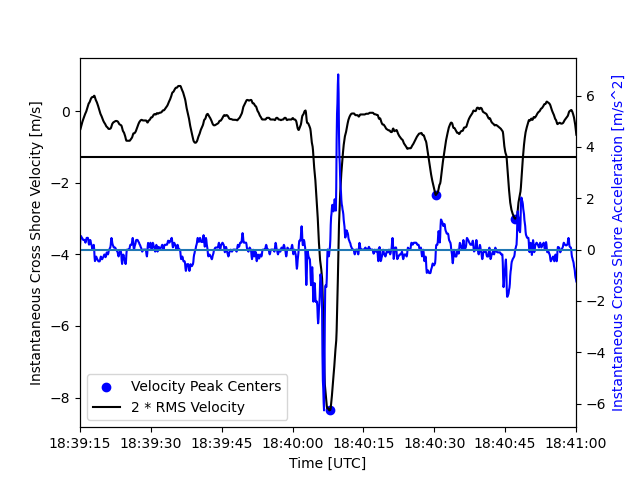

In [9]:
# Compute instantaneous jerk from the acceleration
instantaneous_x_jerk = np.gradient(instantaneous_x_accel, delta_t)
jounce = np.gradient(instantaneous_x_jerk, delta_t)

fig, ax1 = plt.subplots()
# Instantaneous Velocity
ax1.plot(time, instantaneous_x_vel, color='k')
ax1.scatter(time[peak_vel_indices], instantaneous_x_vel[peak_vel_indices], color='b', label='Velocity Peak Centers')
# ax1.scatter(time[start_points], instantaneous_x_vel[start_points], color='g', label='Start Points')
# ax1.scatter(time[end_points], instantaneous_x_vel[end_points], color='r', label='End Points')
ax1.axhline(-vel_threshhold, color='k', label='2 * RMS Velocity')
ax1.set_xlabel('Time [UTC]')
ax1.set_ylabel('Instantaneous Cross Shore Velocity [m/s]')
ax1.legend()
ax1.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))

ax2 = ax1.twinx()
ax2.plot(time, instantaneous_x_accel, color='b')
ax2.set_ylabel('Instantaneous Cross Shore Acceleration [m/s^2]', color='b')
ax2.axhline(0)

# ax3 = ax1.twinx()
# ax3.plot(time, instantaneous_x_jerk, color='orange')
# ax3.set_ylabel('Cross Shore Jerk [m/s^3]', color='orange')

# ax4 = ax3.twinx()
# ax4.plot(time, jounce, color='pink')

Well damn this isn't really going to answer the question either. We will still need to make choices that are robust somehow. We can include a high and low speed threshold. So the center of the events is picked out based on the high speed threshold then the low speed threshold is used to determine the start and end points surrounding that event.


/opt/homebrew/Caskroom/mambaforge/base/envs/surfing-transport/lib/python3.12/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


(18908.777256944446, 18908.77847222222)

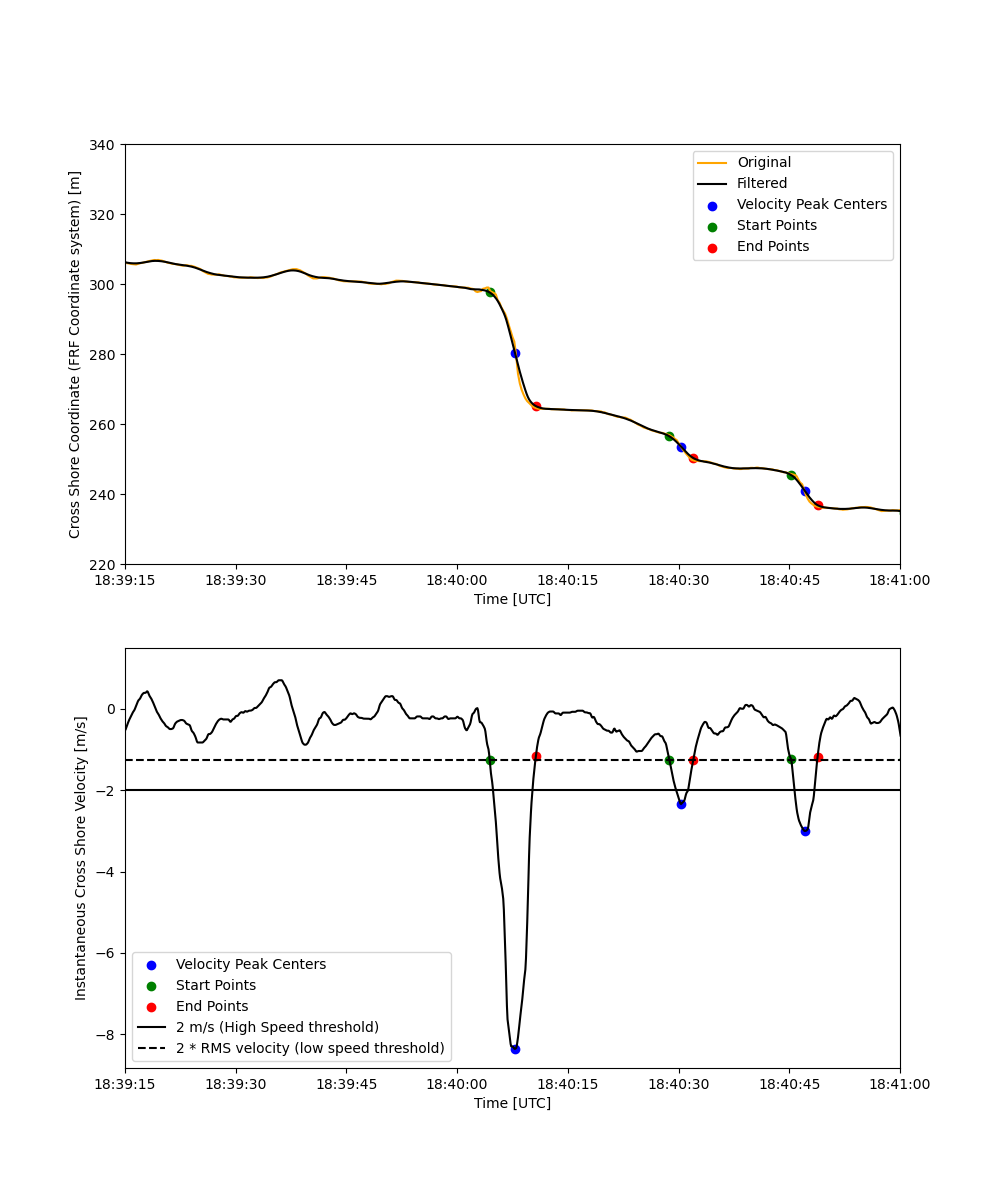

In [10]:
def find_first_condition(data, index, condition):
    """
    Find the first point to the left and right of a given index where a condition is met.
    
    Parameters:
    data (numpy.ndarray): The input data array.
    index (int): The index from which to start the search.
    condition (function): A function that takes a single value and returns True if the condition is met, otherwise False.
    
    Returns:
    tuple: Indices of the first point to the left and right where the condition is met. 
           Returns (None, None) if no such points are found.
    """
    # Ensure data is a numpy array
    data = np.asarray(data)
    
    # Create boolean arrays where condition is met
    condition_met = np.vectorize(condition)(data)
    
    # Find the first point to the left where the condition is met
    left_indices = np.where(condition_met[:index])[0]
    left_index = left_indices[-1] if len(left_indices) > 0 else None
    
    # Find the first point to the right where the condition is met
    right_indices = np.where(condition_met[index:])[0]
    right_index = right_indices[0] + index if len(right_indices) > 0 else None
    
    return left_index, right_index

# Open the mission file 
mission_nc = '../../data/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc, mode='r')
trajectory_num = 5

# Extract the x and y locations of each buoy in the FRF coordinate system
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])

# Get the time values of the mission
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
delta_t = (time[1]-time[0]).total_seconds()

# Define the window size
window_size = 36

# Filter x
x = np.ma.filled(x_locations[trajectory_num,:], np.NaN)
x_filtered = window_mean(x, window_size)

# Filter y 
y = np.ma.filled(y_locations[trajectory_num,:], np.NaN)
y_filtered = window_mean(y, window_size)

# Compute the instantaneous velocity from the filtered signal
instantaneous_x_vel = np.gradient(x_filtered, delta_t)
instantaneous_y_vel = np.gradient(y_filtered, delta_t)

# Compute the instantaneous acceleration from the filtered signal
instantaneous_x_accel = np.gradient(instantaneous_x_vel, delta_t)
instantaneous_y_accel = np.gradient(instantaneous_y_vel, delta_t)

# Find the Peaks in the Acceleration time series - note the negative sign is so that peaks are 
# positive during jumps since the buoys are moving towards the beach which is a decrease in the x coordinate
low_speed_times_rms = 2
low_speed_threshold = -low_speed_times_rms * np.sqrt(np.nanmean(instantaneous_x_vel**2))
vel_threshhold = 2 # change this to be the fraction of the linear phase speed
distance_between_peaks = int(3*(1/delta_t)) # 3 seconds between points
peak_vel_indices = signal.find_peaks(-instantaneous_x_vel, height=vel_threshhold, distance=distance_between_peaks)[0]

# Pick out the start and end points 
start_points = np.empty(peak_vel_indices.size, dtype=int)
end_points = np.empty(peak_vel_indices.size, dtype=int)
for n in np.arange(peak_vel_indices.size):
    left_index, right_index = find_first_condition(instantaneous_x_vel, peak_vel_indices[n], lambda x: x > low_speed_threshold)
    # Add a protection to the make sure it doesn't break if the end point is a NaN value
    if (left_index is None) or (right_index is None):
        continue 
    start_points[n] = left_index
    end_points[n] = right_index

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,12))
ax1.plot(time, x, color='orange', label='Original')
ax1.plot(time, x_filtered, color='k', label='Filtered')
ax1.scatter(time[peak_vel_indices], x_filtered[peak_vel_indices], color='b', label='Velocity Peak Centers')
ax1.scatter(time[start_points], x_filtered[start_points], color='g', label='Start Points')
ax1.scatter(time[end_points], x_filtered[end_points], color='r', label='End Points')
ax1.set_xlabel('Time [UTC]')
ax1.set_ylabel('Cross Shore Coordinate (FRF Coordinate system) [m]')

# Good examples
ax1.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))
ax1.set_ylim(220, 340)

# Bad examples
# ax1.set_xlim(datetime.datetime(2021, 10, 8, 18, 38, 25), datetime.datetime(2021, 10, 8, 18, 38, 45))
# ax1.set_ylim(300, 320)

ax1.legend()

# Instantaneous Velocity
ax2.plot(time, instantaneous_x_vel, color='k')
ax2.scatter(time[peak_vel_indices], instantaneous_x_vel[peak_vel_indices], color='b', label='Velocity Peak Centers')
ax2.scatter(time[start_points], instantaneous_x_vel[start_points], color='g', label='Start Points')
ax2.scatter(time[end_points], instantaneous_x_vel[end_points], color='r', label='End Points')
ax2.axhline(-vel_threshhold, color='k', label=f'{vel_threshhold} m/s (High Speed threshold)')
ax2.axhline(low_speed_threshold, color='k', linestyle='dashed', label=f'{low_speed_times_rms} * RMS velocity (low speed threshold)')
ax2.set_xlabel('Time [UTC]')
ax2.set_ylabel('Instantaneous Cross Shore Velocity [m/s]')
ax2.legend()
# Good Examples
ax2.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))

# Bad examples
# ax2.set_xlim(datetime.datetime(2021, 10, 8, 18, 38, 25), datetime.datetime(2021, 10, 8, 18, 38, 45))



This looks really promising!! We now have two parameters that we need to choose although, it seems that just letting the low threshold be the RMS value of the velocity works well so that parameter may not need to be messed with too much. Now need to run the same sensitivity analysis on the this algorithm.

Now lets try to fit a gaussian to each of the peaks and find the base of the fit gaussian as the start and end points. 

(220.0, 340.0)

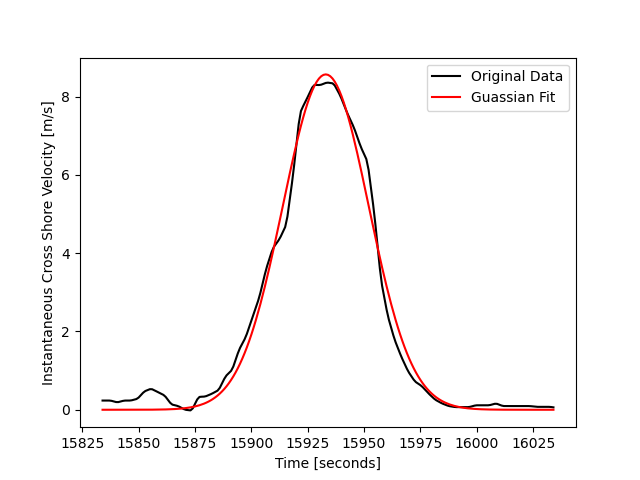

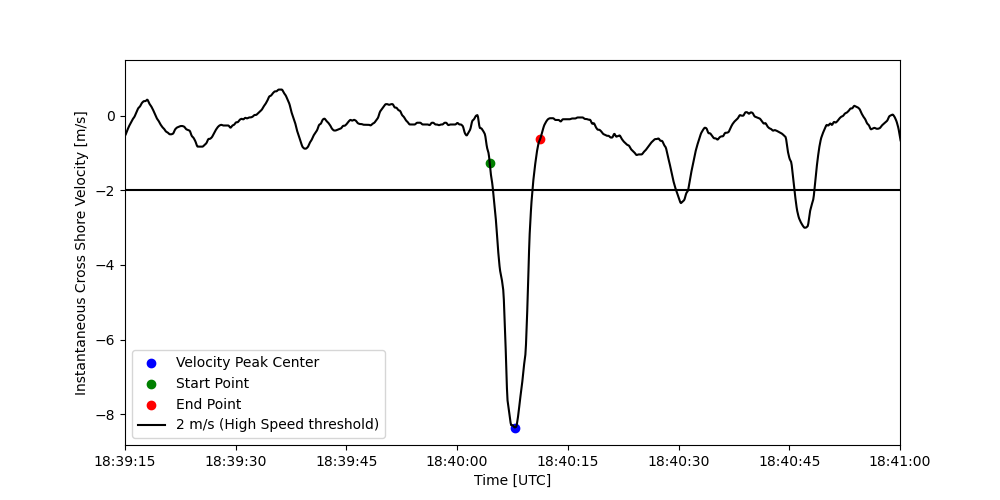

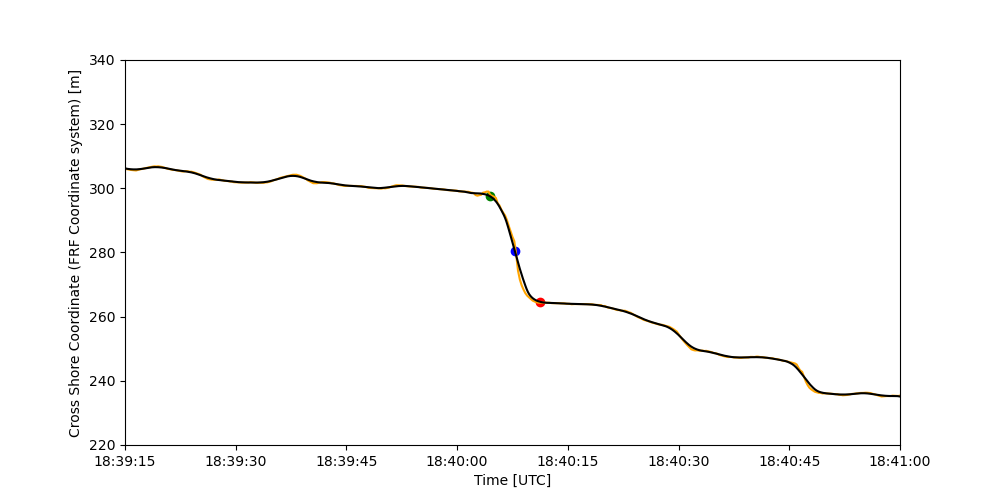

In [11]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

def find_peak_width(signal, peak_index, window=10):
    """
    Compute the width of a peak in a signal by fitting a Gaussian function.

    Parameters:
    - signal: 1D array-like, the signal data.
    - peak_index: int, the index of the peak in the signal.
    - window: int, the number of points on each side of the peak to include in the fit.

    Returns:
    - width: float, the width of the peak defined as 4 standard deviations.
    """
    # Select the region around the peak
    x_data = np.arange(max(0, peak_index - window), min(len(signal), peak_index + window + 1))
    y_data = signal[max(0, peak_index - window):min(len(signal), peak_index + window + 1)]
    
    # Initial guess for the parameters
    initial_guess = [max(y_data), peak_index, 1.0]
    
    # Fit the Gaussian function to the data
    try:
        popt, _ = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
        amplitude, mean, stddev = popt
        # Compute the width as 4 standard deviations
        width = 4 * stddev
    except RuntimeError:
        # If the fitting fails, return None
        width = None
    
    return width

# Look at the data surrounding the peak index
# Select the region around the peak
n = 0
window = 100
peak_index = peak_vel_indices[n]
signal = -1 * instantaneous_x_vel # Flip the signal so the jumps are positive
delta_t = 1/12
x_data = np.arange(max(0, peak_index - window), min(len(signal), peak_index + window + 1))
y_data = signal[max(0, peak_index - window):min(len(signal), peak_index + window + 1)]

# Initial guess for the parameters
initial_guess = [max(y_data), peak_index, 1.0]

# Fit the Data in the window to a guassian function
popt, _ = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
amplitude, mean, stddev = popt
width = 4.3 * stddev # This is the "Full Width at Tenth of Maximum" (FWTM) value for a gaussian
jump_time = width * delta_t

start_point = int(peak_index - width//2)
end_point = int(peak_index + width//2)

# Plot the window of data and the optimized guassian
fig, ax = plt.subplots()
ax.plot(x_data, y_data, color='k', label='Original Data')
ax.plot(x_data, gaussian(x_data, amplitude, mean, stddev), color='r', label='Guassian Fit')
ax.legend()
ax.set_xlabel('Time [seconds]')
ax.set_ylabel('Instantaneous Cross Shore Velocity [m/s]')

# Now lets look at the start and end points following this
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, instantaneous_x_vel, color='k')
ax.scatter(time[peak_vel_indices[0]], instantaneous_x_vel[peak_vel_indices[0]], color='b', label='Velocity Peak Center')
ax.scatter(time[start_point], instantaneous_x_vel[start_point], color='g', label='Start Point')
ax.scatter(time[end_point], instantaneous_x_vel[end_point], color='r', label='End Point')
ax.axhline(-vel_threshhold, color='k', label=f'{vel_threshhold} m/s (High Speed threshold)')
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Instantaneous Cross Shore Velocity [m/s]')
ax.legend()
# Good Examples
ax.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))

# Check the points on the distance curve
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time, x, color='orange', label='Original')
ax.plot(time, x_filtered, color='k', label='Filtered')
ax.scatter(time[peak_vel_indices[n]], x_filtered[peak_vel_indices[n]], color='b', label='Velocity Peak Centers')
ax.scatter(time[start_point], x_filtered[start_point], color='g', label='Start Points')
ax.scatter(time[end_point], x_filtered[end_point], color='r', label='End Points')
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Cross Shore Coordinate (FRF Coordinate system) [m]')

# Good examples
ax.set_xlim(datetime.datetime(2021, 10, 8, 18, 39, 15), datetime.datetime(2021, 10, 8, 18, 41, 0))
ax.set_ylim(220, 340)



This looks perfect and it is very jusifiable which is wonderful!! Now just need to automate it and run it across the rest of the dataset. Now we just have one threshold to pick and the use the FWTM value of the guassian. 